In [1]:
#load up modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

<center><font size="+2">Importing and inspecting the data</font></center>

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [4]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [5]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [6]:
train.columns

Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=132)

In [7]:
train_corr = train.corr()

train_corr['loss'].sort_values(ascending=False)

loss      1.000000
cont2     0.141528
cont7     0.119799
cont3     0.111053
cont11    0.099806
cont12    0.098724
cont6     0.040967
cont8     0.030508
cont10    0.020236
cont14    0.019298
cont9     0.014456
id       -0.001122
cont13   -0.004022
cont1    -0.010237
cont5    -0.011355
cont4    -0.035831
Name: loss, dtype: float64

<center><font size="+2">Need to transform the categorical data</font></center>

In [8]:
#Identifying the category columns

cat_train = []
cat_test = []

for column in train.columns:
    if column.startswith('cat'):
        cat_train.append(column)

for column in test.columns:
    if column.startswith('cat'):
        cat_test.append(column)

In [9]:
#converting categories into a 0,1 sparse matrix

enc = OneHotEncoder()
hot_matrix_train = []
hot_df_train = pd.DataFrame()

for column in train:
    if column in cat_train:
        hot_matrix_train = enc.fit_transform(train[[column]]).toarray()
        df = pd.DataFrame(hot_matrix_train, columns=enc.get_feature_names([column]))
        hot_df_train = pd.concat([hot_df_train,df], axis=1)
        


In [10]:
train_hot = train.drop(train.columns[train.columns.str.contains('cat')], axis=1)

In [11]:
train_hot_ready = pd.concat([train_hot,hot_df_train], axis=1)

In [12]:
train_hot_ready

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
0,1,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,0.347403,0.785784,0.613660,0.473202,0.939556,0.242437,0.289949,0.24564,0.30859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188314,587624,0.507661,0.555782,0.549770,0.802892,0.704268,0.334270,0.382000,0.63475,0.40455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188315,587630,0.484469,0.785784,0.792378,0.189137,0.482436,0.345883,0.370534,0.24564,0.45808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188316,587632,0.438385,0.422197,0.298977,0.383428,0.340543,0.704364,0.562866,0.34987,0.44767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<center><font size="+2">Repeating same steps for test data</font></center>

In [13]:
#converting categories into a 0,1 sparse matrix

enc = OneHotEncoder()
hot_matrix_test = []
hot_df_test = pd.DataFrame()

for column in test:
    if column in cat_test:
        hot_matrix_test = enc.fit_transform(test[[column]]).toarray()
        df = pd.DataFrame(hot_matrix_test, columns=enc.get_feature_names([column]))
        hot_df_test = pd.concat([hot_df_test,df], axis=1)
        


In [14]:
test_hot = test.drop(test.columns[test.columns.str.contains('cat')], axis=1)

In [15]:
test_hot_ready = pd.concat([test_hot,hot_df_test], axis=1)

In [16]:
test_hot_ready

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat116_MW,cat116_MX,cat116_N,cat116_O,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_Y
0,4,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,0.458463,0.245921,0.654310,0.284048,0.281143,0.438917,0.815941,0.39455,0.48740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125542,587621,0.304143,0.488789,0.549770,0.267727,0.674529,0.346948,0.424968,0.47669,0.25753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125543,587627,0.899689,0.555782,0.484196,0.594598,0.794794,0.808958,0.511502,0.72299,0.94438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125544,587629,0.329232,0.358319,0.484196,0.373816,0.302678,0.372125,0.388545,0.31796,0.32128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<center><font size="+2">Normalizing # of columns for test and training set</font></center>

In [17]:
missing_columns = train_hot_ready.columns.difference(test_hot_ready.columns)

In [18]:
missing_columns = missing_columns.drop('loss')

In [19]:
for col in missing_columns:
    test_hot_ready[col] = 0

In [20]:
test_hot_ready

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat116_MB,cat116_MF,cat116_MT,cat116_P,cat116_V,cat116_W,cat116_X,cat89_I,cat90_G,cat92_F
0,4,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,...,0,0,0,0,0,0,0,0,0,0
1,6,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,...,0,0,0,0,0,0,0,0,0,0
2,9,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,...,0,0,0,0,0,0,0,0,0,0
3,12,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,...,0,0,0,0,0,0,0,0,0,0
4,15,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,0.458463,0.245921,0.654310,0.284048,0.281143,0.438917,0.815941,0.39455,0.48740,...,0,0,0,0,0,0,0,0,0,0
125542,587621,0.304143,0.488789,0.549770,0.267727,0.674529,0.346948,0.424968,0.47669,0.25753,...,0,0,0,0,0,0,0,0,0,0
125543,587627,0.899689,0.555782,0.484196,0.594598,0.794794,0.808958,0.511502,0.72299,0.94438,...,0,0,0,0,0,0,0,0,0,0
125544,587629,0.329232,0.358319,0.484196,0.373816,0.302678,0.372125,0.388545,0.31796,0.32128,...,0,0,0,0,0,0,0,0,0,0


In [21]:
missing_columns2 = test_hot_ready.columns.difference(train_hot_ready.columns)

In [22]:
for col in missing_columns2:
    train_hot_ready[col] = 0

In [40]:
cols_test = test_hot_ready.columns.tolist()
cols_train = train_hot_ready.columns.tolist()

In [41]:
#removing loss column to line up lists

cols_train.remove('loss')

In [44]:
#reordering lists and adding loss back into training data

cols_train.sort()
cols_test.sort()

In [48]:
cols_train.append('loss')

In [50]:
#reordering dataframes to match

test_hot_ready = test_hot_ready[cols_test]
train_hot_ready = train_hot_ready[cols_train]

<center><font size="+2">Splitting label and predictors and fitting models</font></center>

In [51]:
def display_scores(scores):
    print("Scores:", -scores)
    print("Mean:", -scores.mean())
    print("Standard deviation:", scores.std())

In [52]:
x = train_hot_ready.drop(columns=['loss'])
y = train_hot_ready['loss']

Linear Regression

In [53]:
lin_reg = LinearRegression()
lin_reg.fit(x,y)

LinearRegression()

In [54]:
loss_predictions_lin = lin_reg.predict(x)
mae_linreg_train = mean_absolute_error(y, loss_predictions_lin)
print("Training MAE is: ",mae_linreg_train," for Lin Reg")

Training MAE is:  1288.811300690341  for Lin Reg


In [55]:
scores_lin = cross_val_score(lin_reg, x, y, scoring="neg_mean_absolute_error", cv=10)
display_scores(scores_lin)

Scores: [ 1368.84126522  1303.74134054  3004.70966119  1478.91745118
  1328.62659738  1292.93344874  1308.93864212  1312.01933381
 14451.1480156   1304.82426847]
Mean: 2815.4700024250533
Standard deviation: 3910.62805060594


In [56]:
lin_difference = y - loss_predictions_lin

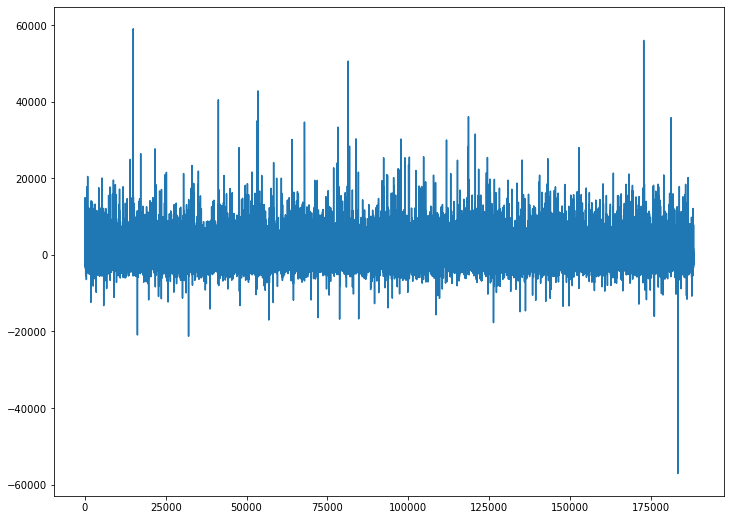

In [57]:
plt.figure(figsize=(12, 9))
plt.plot(lin_difference)
plt.show()

Ridge

In [238]:
ridge = Ridge(alpha=1, solver="cholesky")
ridge.fit(x,y)

Ridge(alpha=1, solver='cholesky')

In [239]:
loss_predictions_ridge = ridge.predict(x)
mae_ridge = mean_absolute_error(y, loss_predictions_ridge)
print("Training MAE is: ",mae_ridge," for Ridge Reg")

Training MAE is:  1289.879882372457  for Ridge Reg


In [240]:
scores_ridge = cross_val_score(ridge, x, y, scoring="neg_mean_absolute_error", cv=10)
display_scores(scores_ridge)

Scores: [1310.04424447 1302.87154997 1293.03603032 1279.30871627 1310.34660275
 1293.00684865 1307.34185911 1309.88173682 1290.11267231 1300.62442212]
Mean: 1299.6574682784692
Standard deviation: 9.951093337288725


In [262]:
ridge_difference = y - loss_predictions_ridge

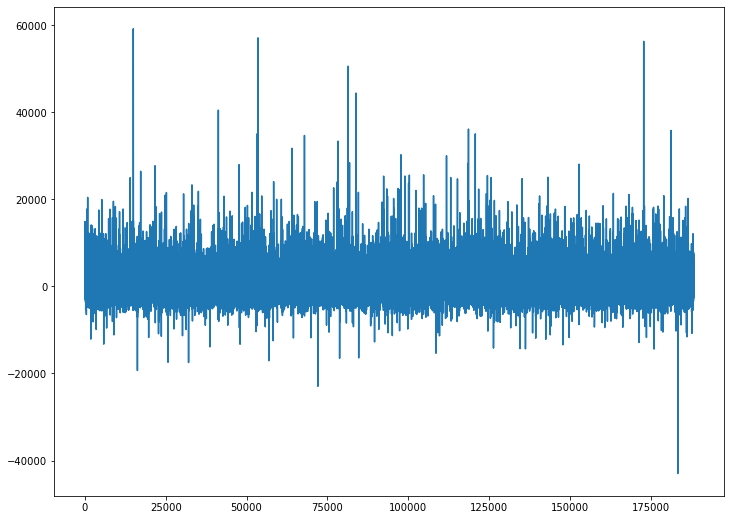

In [263]:
plt.figure(figsize=(12, 9))
plt.plot(ridge_difference)
plt.show()

Lasso

In [241]:
lasso_reg = Lasso()
lasso_reg.fit(x,y)

Z:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4952599380.511353, tolerance: 158821220.48161286
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [242]:
loss_predictions_lasso = lasso_reg.predict(x)
mae_lasso = mean_absolute_error(y, loss_predictions_lasso)
print("Training MAE is: ",mae_lasso," for Lasso")

Training MAE is:  1297.6090496458837  for Lasso


In [243]:
scores_lasso = cross_val_score(lasso_reg, x, y, scoring="neg_mean_absolute_error", cv=5)
display_scores(scores_lasso)

Scores: [1307.82213602 1290.6795929  1301.16943892 1306.49685621 1299.02353356]
Mean: 1301.0383115244865
Standard deviation: 6.11875086923895


In [264]:
lasso_difference = y - loss_predictions_lasso

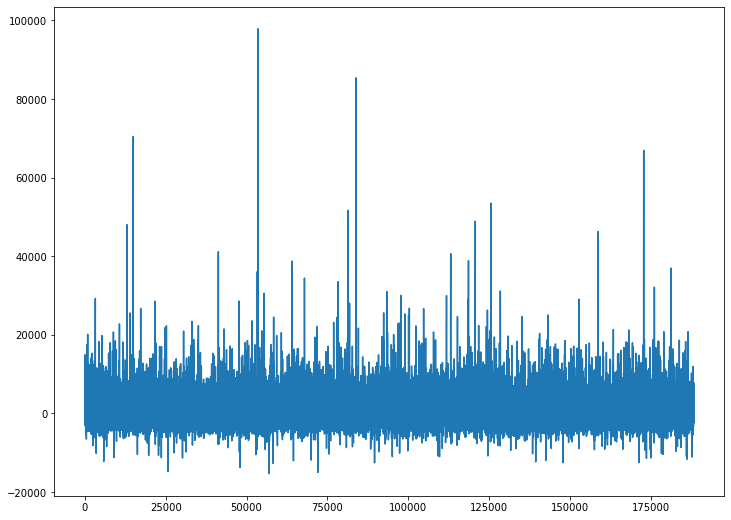

In [265]:
plt.figure(figsize=(12, 9))
plt.plot(lasso_difference)
plt.show()

Elastic Net

In [58]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(x,y)

ElasticNet(alpha=0.1)

In [59]:
loss_predictions_elastic = elastic_net.predict(x)
mae_elastic = mean_absolute_error(y, loss_predictions_elastic)
print("Training MAE is: ",mae_elastic," for Elastic Net")

Training MAE is:  1309.0938465104712  for Elastic Net


In [60]:
scores_elastic = cross_val_score(elastic_net, x, y, scoring="neg_mean_absolute_error", cv=10)
display_scores(scores_elastic)

Scores: [1323.34558003 1309.3279113  1309.86871991 1292.06472899 1320.18712675
 1304.71138707 1321.29113306 1314.40956696 1302.65986289 1306.52561068]
Mean: 1310.4391627639839
Standard deviation: 9.181223717559979


In [61]:
elastic_difference = y - loss_predictions_elastic

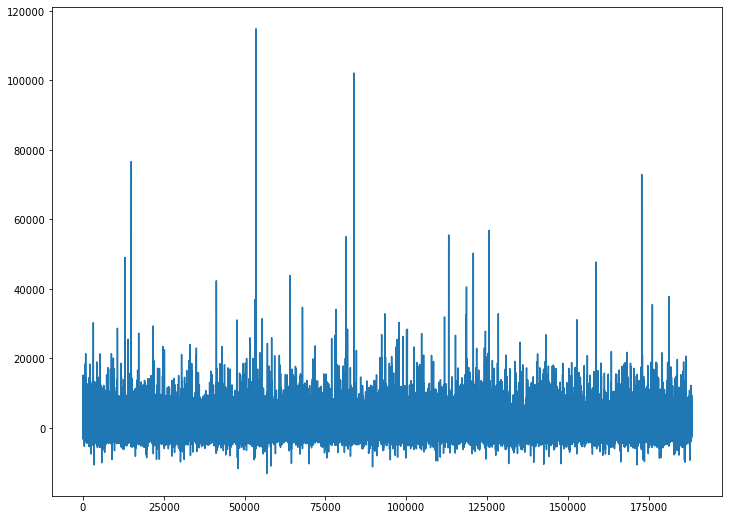

In [62]:
plt.figure(figsize=(12, 9))
plt.plot(elastic_difference)
plt.show()

<center><font size="+2">Using models on test data and exporting results</font></center>

In [63]:
test_lin = lin_reg.predict(test_hot_ready)
#test_ridge = ridge.predict(test_hot_ready)
#test_lasso = lasso_reg.predict(test_hot_ready)
test_elastic = elastic_net.predict(test_hot_ready)

In [65]:

df_list = ['df_lin','df_ridge','df_lasso','df_elastic']



df_lin = pd.DataFrame({
        'id':test_hot_ready['id'],
        'loss':test_lin
         })

#df_ridge = pd.DataFrame({
#        'id':test_hot_ready['id'],
#        'loss':test_ridge
#         })

#df_lasso = pd.DataFrame({
#        'id':test_hot_ready['id'],
#        'loss':test_lasso
#         })

df_elastic = pd.DataFrame({
        'id':test_hot_ready['id'],
        'loss':test_elastic
         })


In [66]:
df_lin.to_csv('lin_approach.csv')
#df_ridge.to_csv('ridge_approach.csv')
#df_lasso.to_csv('lasso_approach.csv')
df_elastic.to_csv('elastic_approach.csv')